In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaselineV2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.custom_baseline_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 36)             9252      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 18)             2610      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               4864      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/146 [..............................] - ETA: 28:40 - loss: 2.3984

 10/146 [=>............................] - ETA: 0s - loss: 2.3963   

 20/146 [===>..........................] - ETA: 0s - loss: 2.3928

 30/146 [=====>........................] - ETA: 0s - loss: 2.3864

 40/146 [=======>......................] - ETA: 0s - loss: 2.3766

 51/146 [=========>....................] - ETA: 0s - loss: 2.3640

 62/146 [===========>..................] - ETA: 0s - loss: 2.3517

 74/146 [==============>...............] - ETA: 0s - loss: 2.3385

 86/146 [================>.............] - ETA: 0s - loss: 2.3254

 99/146 [===================>..........] - ETA: 0s - loss: 2.3116

112/146 [======================>.......] - ETA: 0s - loss: 2.2981

125/146 [========================>.....] - ETA: 0s - loss: 2.2853

137/146 [===========================>..] - ETA: 0s - loss: 2.2741

146/146 [==============================] - ETA: 0s - loss: 2.2660

146/146 [==============================] - 13s 8ms/step - loss: 2.2652 - val_loss: 1.9757


Epoch 2/100
  1/146 [..............................] - ETA: 0s - loss: 1.9590



 15/146 [==>...........................] - ETA: 0s - loss: 1.9433

 28/146 [====>.........................] - ETA: 0s - loss: 1.9454

 41/146 [=======>......................] - ETA: 0s - loss: 1.9452

 54/146 [==========>...................] - ETA: 0s - loss: 1.9437

 67/146 [============>.................] - ETA: 0s - loss: 1.9418

 80/146 [===============>..............] - ETA: 0s - loss: 1.9398

 93/146 [==================>...........] - ETA: 0s - loss: 1.9378

106/146 [====================>.........] - ETA: 0s - loss: 1.9357



119/146 [=======================>......] - ETA: 0s - loss: 1.9338



132/146 [==========================>...] - ETA: 0s - loss: 1.9318

145/146 [============================>.] - ETA: 0s - loss: 1.9299

146/146 [==============================] - 1s 4ms/step - loss: 1.9296 - val_loss: 1.8654


Epoch 3/100


  1/146 [..............................] - ETA: 0s - loss: 1.8409



 14/146 [=>............................] - ETA: 0s - loss: 1.8541

 26/146 [====>.........................] - ETA: 0s - loss: 1.8513

 39/146 [=======>......................] - ETA: 0s - loss: 1.8492

 51/146 [=========>....................] - ETA: 0s - loss: 1.8473

 64/146 [============>.................] - ETA: 0s - loss: 1.8452

 77/146 [==============>...............] - ETA: 0s - loss: 1.8430

 90/146 [=================>............] - ETA: 0s - loss: 1.8414

102/146 [===================>..........] - ETA: 0s - loss: 1.8402

114/146 [======================>.......] - ETA: 0s - loss: 1.8393

126/146 [========================>.....] - ETA: 0s - loss: 1.8384

138/146 [===========================>..] - ETA: 0s - loss: 1.8374



146/146 [==============================] - 1s 4ms/step - loss: 1.8367 - val_loss: 1.8297


Epoch 4/100


  1/146 [..............................] - ETA: 0s - loss: 1.7824

 13/146 [=>............................] - ETA: 0s - loss: 1.8084

 25/146 [====>.........................] - ETA: 0s - loss: 1.8092

 37/146 [======>.......................] - ETA: 0s - loss: 1.8072

 49/146 [=========>....................] - ETA: 0s - loss: 1.8050

 61/146 [===========>..................] - ETA: 0s - loss: 1.8033

 73/146 [==============>...............] - ETA: 0s - loss: 1.8017

 85/146 [================>.............] - ETA: 0s - loss: 1.8004



 98/146 [===================>..........] - ETA: 0s - loss: 1.7990

110/146 [=====================>........] - ETA: 0s - loss: 1.7979

122/146 [========================>.....] - ETA: 0s - loss: 1.7968



134/146 [==========================>...] - ETA: 0s - loss: 1.7959

144/146 [============================>.] - ETA: 0s - loss: 1.7951

146/146 [==============================] - 1s 5ms/step - loss: 1.7949 - val_loss: 1.7922


Epoch 5/100


  1/146 [..............................] - ETA: 0s - loss: 1.7555

 12/146 [=>............................] - ETA: 0s - loss: 1.7666

 23/146 [===>..........................] - ETA: 0s - loss: 1.7667

 33/146 [=====>........................] - ETA: 0s - loss: 1.7672

 44/146 [========>.....................] - ETA: 0s - loss: 1.7665

 57/146 [==========>...................] - ETA: 0s - loss: 1.7653



 70/146 [=============>................] - ETA: 0s - loss: 1.7644

 84/146 [================>.............] - ETA: 0s - loss: 1.7634

 98/146 [===================>..........] - ETA: 0s - loss: 1.7622



112/146 [======================>.......] - ETA: 0s - loss: 1.7612

126/146 [========================>.....] - ETA: 0s - loss: 1.7603

140/146 [===========================>..] - ETA: 0s - loss: 1.7595

146/146 [==============================] - 1s 4ms/step - loss: 1.7591 - val_loss: 1.7723


Epoch 6/100


  1/146 [..............................] - ETA: 0s - loss: 1.7275

 14/146 [=>............................] - ETA: 0s - loss: 1.7535

 26/146 [====>.........................] - ETA: 0s - loss: 1.7528

 39/146 [=======>......................] - ETA: 0s - loss: 1.7494

 53/146 [=========>....................] - ETA: 0s - loss: 1.7463

 66/146 [============>.................] - ETA: 0s - loss: 1.7437

 78/146 [===============>..............] - ETA: 0s - loss: 1.7417

 91/146 [=================>............] - ETA: 0s - loss: 1.7400

103/146 [====================>.........] - ETA: 0s - loss: 1.7387

116/146 [======================>.......] - ETA: 0s - loss: 1.7376

129/146 [=========================>....] - ETA: 0s - loss: 1.7365

142/146 [============================>.] - ETA: 0s - loss: 1.7355

146/146 [==============================] - 1s 4ms/step - loss: 1.7351 - val_loss: 1.7360


Epoch 7/100


  1/146 [..............................] - ETA: 0s - loss: 1.6952

 13/146 [=>............................] - ETA: 0s - loss: 1.6918

 26/146 [====>.........................] - ETA: 0s - loss: 1.6955

 39/146 [=======>......................] - ETA: 0s - loss: 1.6977

 52/146 [=========>....................] - ETA: 0s - loss: 1.6989

 65/146 [============>.................] - ETA: 0s - loss: 1.6989

 78/146 [===============>..............] - ETA: 0s - loss: 1.6985

 91/146 [=================>............] - ETA: 0s - loss: 1.6983

104/146 [====================>.........] - ETA: 0s - loss: 1.6981

116/146 [======================>.......] - ETA: 0s - loss: 1.6979

129/146 [=========================>....] - ETA: 0s - loss: 1.6977



142/146 [============================>.] - ETA: 0s - loss: 1.6975

146/146 [==============================] - 1s 4ms/step - loss: 1.6974 - val_loss: 1.7143


Epoch 8/100


  1/146 [..............................] - ETA: 0s - loss: 1.6787

 12/146 [=>............................] - ETA: 0s - loss: 1.7083

 22/146 [===>..........................] - ETA: 0s - loss: 1.7055

 32/146 [=====>........................] - ETA: 0s - loss: 1.7011

 42/146 [=======>......................] - ETA: 0s - loss: 1.6968

 52/146 [=========>....................] - ETA: 0s - loss: 1.6936



 65/146 [============>.................] - ETA: 0s - loss: 1.6910



 78/146 [===============>..............] - ETA: 0s - loss: 1.6894

 90/146 [=================>............] - ETA: 0s - loss: 1.6881

103/146 [====================>.........] - ETA: 0s - loss: 1.6867



117/146 [=======================>......] - ETA: 0s - loss: 1.6853

130/146 [=========================>....] - ETA: 0s - loss: 1.6840

144/146 [============================>.] - ETA: 0s - loss: 1.6827

146/146 [==============================] - 1s 5ms/step - loss: 1.6825 - val_loss: 1.6816


Epoch 9/100
  1/146 [..............................] - ETA: 0s - loss: 1.6137

 14/146 [=>............................] - ETA: 0s - loss: 1.6430

 27/146 [====>.........................] - ETA: 0s - loss: 1.6511

 40/146 [=======>......................] - ETA: 0s - loss: 1.6531

 53/146 [=========>....................] - ETA: 0s - loss: 1.6530

 67/146 [============>.................] - ETA: 0s - loss: 1.6522

 80/146 [===============>..............] - ETA: 0s - loss: 1.6516

 93/146 [==================>...........] - ETA: 0s - loss: 1.6509

106/146 [====================>.........] - ETA: 0s - loss: 1.6503

119/146 [=======================>......] - ETA: 0s - loss: 1.6497

132/146 [==========================>...] - ETA: 0s - loss: 1.6491

145/146 [============================>.] - ETA: 0s - loss: 1.6485



146/146 [==============================] - 1s 4ms/step - loss: 1.6484 - val_loss: 1.6605


Epoch 10/100
  1/146 [..............................] - ETA: 0s - loss: 1.5703

 14/146 [=>............................] - ETA: 0s - loss: 1.6260

 27/146 [====>.........................] - ETA: 0s - loss: 1.6264

 40/146 [=======>......................] - ETA: 0s - loss: 1.6286

 53/146 [=========>....................] - ETA: 0s - loss: 1.6293

 66/146 [============>.................] - ETA: 0s - loss: 1.6294

 80/146 [===============>..............] - ETA: 0s - loss: 1.6288

 94/146 [==================>...........] - ETA: 0s - loss: 1.6280

107/146 [====================>.........] - ETA: 0s - loss: 1.6275

120/146 [=======================>......] - ETA: 0s - loss: 1.6269

133/146 [==========================>...] - ETA: 0s - loss: 1.6265

146/146 [==============================] - ETA: 0s - loss: 1.6261

146/146 [==============================] - 1s 4ms/step - loss: 1.6261 - val_loss: 1.6510


Epoch 11/100
  1/146 [..............................]

 - ETA: 0s - loss: 1.5823

 14/146 [=>............................] - ETA: 0s - loss: 1.6208

 26/146 [====>.........................] - ETA: 0s - loss: 1.6220

 39/146 [=======>......................] - ETA: 0s - loss: 1.6195

 52/146 [=========>....................] - ETA: 0s - loss: 1.6175

 65/146 [============>.................] - ETA: 0s - loss: 1.6158

 76/146 [==============>...............] - ETA: 0s - loss: 1.6147

 87/146 [================>.............] - ETA: 0s - loss: 1.6137

 98/146 [===================>..........] - ETA: 0s - loss: 1.6129

109/146 [=====================>........] - ETA: 0s - loss: 1.6121



121/146 [=======================>......] - ETA: 0s - loss: 1.6115

132/146 [==========================>...] - ETA: 0s - loss: 1.6110

144/146 [============================>.] - ETA: 0s - loss: 1.6106

146/146 [==============================] - 1s 5ms/step - loss: 1.6105 - val_loss: 1.6416


Epoch 12/100


  1/146 [..............................] - ETA: 0s - loss: 1.6153



 15/146 [==>...........................] - ETA: 0s - loss: 1.6086



 29/146 [====>.........................] - ETA: 0s - loss: 1.6042

 43/146 [=======>......................] - ETA: 0s - loss: 1.6032

 56/146 [==========>...................] - ETA: 0s - loss: 1.6021

 70/146 [=============>................] - ETA: 0s - loss: 1.6011

 82/146 [===============>..............] - ETA: 0s - loss: 1.6004

 95/146 [==================>...........] - ETA: 0s - loss: 1.5999

107/146 [====================>.........] - ETA: 0s - loss: 1.5994



119/146 [=======================>......] - ETA: 0s - loss: 1.5988



131/146 [=========================>....] - ETA: 0s - loss: 1.5985

144/146 [============================>.] - ETA: 0s - loss: 1.5981

146/146 [==============================] - 1s 4ms/step - loss: 1.5981 - val_loss: 1.6179


Epoch 13/100


  1/146 [..............................] - ETA: 0s - loss: 1.5477

 14/146 [=>............................] - ETA: 0s - loss: 1.5796

 27/146 [====>.........................] - ETA: 0s - loss: 1.5807

 40/146 [=======>......................] - ETA: 0s - loss: 1.5801

 53/146 [=========>....................] - ETA: 0s - loss: 1.5800

 66/146 [============>.................] - ETA: 0s - loss: 1.5802

 80/146 [===============>..............] - ETA: 0s - loss: 1.5801

 93/146 [==================>...........] - ETA: 0s - loss: 1.5801

106/146 [====================>.........] - ETA: 0s - loss: 1.5801

119/146 [=======================>......] - ETA: 0s - loss: 1.5802

133/146 [==========================>...] - ETA: 0s - loss: 1.5804

146/146 [==============================] - ETA: 0s - loss: 1.5805

146/146 [==============================] - 1s 4ms/step - loss: 1.5806 - val_loss: 1.6105


Epoch 14/100


  1/146 [..............................] - ETA: 0s - loss: 1.5529

 14/146 [=>............................] - ETA: 0s - loss: 1.5917

 27/146 [====>.........................] - ETA: 0s - loss: 1.5917

 40/146 [=======>......................] - ETA: 0s - loss: 1.5883

 53/146 [=========>....................] - ETA: 0s - loss: 1.5853



 66/146 [============>.................] - ETA: 0s - loss: 1.5834

 78/146 [===============>..............] - ETA: 0s - loss: 1.5821

 91/146 [=================>............] - ETA: 0s - loss: 1.5808



104/146 [====================>.........] - ETA: 0s - loss: 1.5796

117/146 [=======================>......] - ETA: 0s - loss: 1.5786

130/146 [=========================>....] - ETA: 0s - loss: 1.5780

142/146 [============================>.] - ETA: 0s - loss: 1.5776

146/146 [==============================] - 1s 4ms/step - loss: 1.5775 - val_loss: 1.6148


Epoch 15/100
  1/146 [..............................] - ETA: 0s - loss: 1.5337

 13/146 [=>............................] - ETA: 0s - loss: 1.5681

 25/146 [====>.........................] - ETA: 0s - loss: 1.5709

 38/146 [======>.......................] - ETA: 0s - loss: 1.5723

 50/146 [=========>....................] - ETA: 0s - loss: 1.5720

 62/146 [===========>..................] - ETA: 0s - loss: 1.5712

 74/146 [==============>...............] - ETA: 0s - loss: 1.5703

 87/146 [================>.............] - ETA: 0s - loss: 1.5694

 99/146 [===================>..........] - ETA: 0s - loss: 1.5686

111/146 [=====================>........] - ETA: 0s - loss: 1.5679

124/146 [========================>.....] - ETA: 0s - loss: 1.5674

137/146 [===========================>..] - ETA: 0s - loss: 1.5672

146/146 [==============================] - 1s 5ms/step - loss: 1.5670 - val_loss: 1.6006


Epoch 16/100


  1/146 [..............................] - ETA: 0s - loss: 1.5776

 13/146 [=>............................] - ETA: 0s - loss: 1.5788

 26/146 [====>.........................] - ETA: 0s - loss: 1.5744

 38/146 [======>.......................] - ETA: 0s - loss: 1.5717

 50/146 [=========>....................] - ETA: 0s - loss: 1.5695

 63/146 [===========>..................] - ETA: 0s - loss: 1.5679

 76/146 [==============>...............] - ETA: 0s - loss: 1.5664

 89/146 [=================>............] - ETA: 0s - loss: 1.5653

101/146 [===================>..........] - ETA: 0s - loss: 1.5645

113/146 [======================>.......] - ETA: 0s - loss: 1.5639

125/146 [========================>.....] - ETA: 0s - loss: 1.5634

138/146 [===========================>..] - ETA: 0s - loss: 1.5630

146/146 [==============================] - 1s 5ms/step - loss: 1.5627 - val_loss: 1.6017


Epoch 17/100
  1/146 [..............................] - ETA: 0s - loss: 1.5622

 14/146 [=>............................] - ETA: 0s - loss: 1.5796

 26/146 [====>.........................] - ETA: 0s - loss: 1.5748

 39/146 [=======>......................] - ETA: 0s - loss: 1.5696

 51/146 [=========>....................] - ETA: 0s - loss: 1.5662

 63/146 [===========>..................] - ETA: 0s - loss: 1.5640

 75/146 [==============>...............] - ETA: 0s - loss: 1.5621

 87/146 [================>.............] - ETA: 0s - loss: 1.5609

 99/146 [===================>..........] - ETA: 0s - loss: 1.5600

111/146 [=====================>........] - ETA: 0s - loss: 1.5592

123/146 [========================>.....] - ETA: 0s - loss: 1.5586

135/146 [==========================>...] - ETA: 0s - loss: 1.5581

146/146 [==============================] - 1s 5ms/step - loss: 1.5576 - val_loss: 1.5931


Epoch 18/100
  1/146 [..............................] - ETA: 0s - loss: 1.5187

 13/146 [=>............................] - ETA: 0s - loss: 1.5317

 25/146 [====>.........................] - ETA: 0s - loss: 1.5378

 37/146 [======>.......................] - ETA: 0s - loss: 1.5408



 48/146 [========>.....................] - ETA: 0s - loss: 1.5423

 60/146 [===========>..................] - ETA: 0s - loss: 1.5427

 72/146 [=============>................] - ETA: 0s - loss: 1.5426

 84/146 [================>.............] - ETA: 0s - loss: 1.5427

 96/146 [==================>...........] - ETA: 0s - loss: 1.5428

108/146 [=====================>........] - ETA: 0s - loss: 1.5428

120/146 [=======================>......] - ETA: 0s - loss: 1.5429

132/146 [==========================>...] - ETA: 0s - loss: 1.5430

144/146 [============================>.] - ETA: 0s - loss: 1.5431

146/146 [==============================] - 1s 5ms/step - loss: 1.5431 - val_loss: 1.5974


Epoch 19/100
  1/146 [..............................] - ETA: 0s - loss: 1.5112

 13/146 [=>............................] - ETA: 0s - loss: 1.5550

 25/146 [====>.........................] - ETA: 0s - loss: 1.5513

 37/146 [======>.......................] - ETA: 0s - loss: 1.5484

 49/146 [=========>....................] - ETA: 0s - loss: 1.5462

 61/146 [===========>..................] - ETA: 0s - loss: 1.5446

 73/146 [==============>...............] - ETA: 0s - loss: 1.5435

 85/146 [================>.............] - ETA: 0s - loss: 1.5429

 97/146 [==================>...........] - ETA: 0s - loss: 1.5427

109/146 [=====================>........] - ETA: 0s - loss: 1.5427

121/146 [=======================>......] - ETA: 0s - loss: 1.5426

133/146 [==========================>...] - ETA: 0s - loss: 1.5424

145/146 [============================>.] - ETA: 0s - loss: 1.5423

146/146 [==============================] - 1s 5ms/step - loss: 1.5422 - val_loss: 1.5841


Epoch 20/100


  1/146 [..............................] - ETA: 0s - loss: 1.4743

 13/146 [=>............................] - ETA: 0s - loss: 1.5080

 25/146 [====>.........................] - ETA: 0s - loss: 1.5165

 37/146 [======>.......................] - ETA: 0s - loss: 1.5208

 49/146 [=========>....................] - ETA: 0s - loss: 1.5231

 61/146 [===========>..................] - ETA: 0s - loss: 1.5247

 72/146 [=============>................] - ETA: 0s - loss: 1.5255

 84/146 [================>.............] - ETA: 0s - loss: 1.5264

 96/146 [==================>...........] - ETA: 0s - loss: 1.5271

108/146 [=====================>........] - ETA: 0s - loss: 1.5278

120/146 [=======================>......] - ETA: 0s - loss: 1.5283

132/146 [==========================>...] - ETA: 0s - loss: 1.5288

144/146 [============================>.] - ETA: 0s - loss: 1.5293

146/146 [==============================] - 1s 5ms/step - loss: 1.5294 - val_loss: 1.5783


Epoch 21/100


  1/146 [..............................] - ETA: 0s - loss: 1.5486

 13/146 [=>............................] - ETA: 0s - loss: 1.5434

 25/146 [====>.........................] - ETA: 0s - loss: 1.5352

 37/146 [======>.......................] - ETA: 0s - loss: 1.5321

 49/146 [=========>....................] - ETA: 0s - loss: 1.5314

 61/146 [===========>..................] - ETA: 0s - loss: 1.5317

 73/146 [==============>...............] - ETA: 0s - loss: 1.5319

 85/146 [================>.............] - ETA: 0s - loss: 1.5319

 97/146 [==================>...........] - ETA: 0s - loss: 1.5318

110/146 [=====================>........] - ETA: 0s - loss: 1.5317

122/146 [========================>.....] - ETA: 0s - loss: 1.5315

134/146 [==========================>...] - ETA: 0s - loss: 1.5314

145/146 [============================>.] - ETA: 0s - loss: 1.5313

146/146 [==============================] - 1s 5ms/step - loss: 1.5313 - val_loss: 1.5756


Epoch 22/100


  1/146 [..............................] - ETA: 1s - loss: 1.5279

 12/146 [=>............................] - ETA: 0s - loss: 1.5188

 24/146 [===>..........................] - ETA: 0s - loss: 1.5214

 36/146 [======>.......................] - ETA: 0s - loss: 1.5212

 48/146 [========>.....................] - ETA: 0s - loss: 1.5216

 60/146 [===========>..................] - ETA: 0s - loss: 1.5219

 72/146 [=============>................] - ETA: 0s - loss: 1.5222

 84/146 [================>.............] - ETA: 0s - loss: 1.5222

 96/146 [==================>...........] - ETA: 0s - loss: 1.5225

108/146 [=====================>........] - ETA: 0s - loss: 1.5227

120/146 [=======================>......] - ETA: 0s - loss: 1.5229

131/146 [=========================>....] - ETA: 0s - loss: 1.5231

143/146 [============================>.] - ETA: 0s - loss: 1.5233

146/146 [==============================] - 1s 5ms/step - loss: 1.5233 - val_loss: 1.5760


Epoch 23/100


  1/146 [..............................] - ETA: 0s - loss: 1.5648

 13/146 [=>............................] - ETA: 0s - loss: 1.5401

 25/146 [====>.........................] - ETA: 0s - loss: 1.5351

 37/146 [======>.......................] - ETA: 0s - loss: 1.5324

 49/146 [=========>....................] - ETA: 0s - loss: 1.5305

 61/146 [===========>..................] - ETA: 0s - loss: 1.5290

 73/146 [==============>...............] - ETA: 0s - loss: 1.5280

 85/146 [================>.............] - ETA: 0s - loss: 1.5271

 97/146 [==================>...........] - ETA: 0s - loss: 1.5265

109/146 [=====================>........] - ETA: 0s - loss: 1.5259

121/146 [=======================>......] - ETA: 0s - loss: 1.5253

133/146 [==========================>...] - ETA: 0s - loss: 1.5248

145/146 [============================>.] - ETA: 0s - loss: 1.5244

146/146 [==============================] - 1s 5ms/step - loss: 1.5243 - val_loss: 1.5937


Epoch 24/100
  1/146 [..............................] - ETA: 0s - loss: 1.5128

 13/146 [=>............................] - ETA: 0s - loss: 1.5275

 25/146 [====>.........................] - ETA: 0s - loss: 1.5244

 37/146 [======>.......................] - ETA: 0s - loss: 1.5236

 49/146 [=========>....................] - ETA: 0s - loss: 1.5234

 61/146 [===========>..................] - ETA: 0s - loss: 1.5234

 73/146 [==============>...............] - ETA: 0s - loss: 1.5234

 85/146 [================>.............] - ETA: 0s - loss: 1.5233

 97/146 [==================>...........] - ETA: 0s - loss: 1.5231

109/146 [=====================>........] - ETA: 0s - loss: 1.5227

121/146 [=======================>......] - ETA: 0s - loss: 1.5225

133/146 [==========================>...] - ETA: 0s - loss: 1.5222

145/146 [============================>.] - ETA: 0s - loss: 1.5219

146/146 [==============================] - 1s 5ms/step - loss: 1.5219 - val_loss: 1.5684


Epoch 25/100


  1/146 [..............................] - ETA: 0s - loss: 1.5074

 13/146 [=>............................] - ETA: 0s - loss: 1.5105

 25/146 [====>.........................] - ETA: 0s - loss: 1.5064

 37/146 [======>.......................] - ETA: 0s - loss: 1.5061

 49/146 [=========>....................] - ETA: 0s - loss: 1.5055



 61/146 [===========>..................] - ETA: 0s - loss: 1.5050

 73/146 [==============>...............] - ETA: 0s - loss: 1.5047

 85/146 [================>.............] - ETA: 0s - loss: 1.5049

 97/146 [==================>...........] - ETA: 0s - loss: 1.5051

109/146 [=====================>........] - ETA: 0s - loss: 1.5053

121/146 [=======================>......] - ETA: 0s - loss: 1.5057

133/146 [==========================>...] - ETA: 0s - loss: 1.5061

145/146 [============================>.] - ETA: 0s - loss: 1.5065

146/146 [==============================] - 1s 5ms/step - loss: 1.5066 - val_loss: 1.5693


Epoch 26/100
  1/146 [..............................] - ETA: 0s - loss: 1.4939

 13/146 [=>............................] - ETA: 0s - loss: 1.5090

 25/146 [====>.........................] - ETA: 0s - loss: 1.5086

 37/146 [======>.......................] - ETA: 0s - loss: 1.5093

 49/146 [=========>....................] - ETA: 0s - loss: 1.5092

 61/146 [===========>..................] - ETA: 0s - loss: 1.5086

 73/146 [==============>...............] - ETA: 0s - loss: 1.5080

 85/146 [================>.............] - ETA: 0s - loss: 1.5075

 97/146 [==================>...........] - ETA: 0s - loss: 1.5073

110/146 [=====================>........] - ETA: 0s - loss: 1.5073

122/146 [========================>.....] - ETA: 0s - loss: 1.5071

134/146 [==========================>...] - ETA: 0s - loss: 1.5071

146/146 [==============================] - 1s 5ms/step - loss: 1.5070 - val_loss: 1.5638


Epoch 27/100


  1/146 [..............................] - ETA: 0s - loss: 1.4603

 13/146 [=>............................] - ETA: 0s - loss: 1.5135

 25/146 [====>.........................] - ETA: 0s - loss: 1.5148

 37/146 [======>.......................] - ETA: 0s - loss: 1.5137

 49/146 [=========>....................] - ETA: 0s - loss: 1.5128

 61/146 [===========>..................] - ETA: 0s - loss: 1.5120

 74/146 [==============>...............] - ETA: 0s - loss: 1.5113

 86/146 [================>.............] - ETA: 0s - loss: 1.5109

 99/146 [===================>..........] - ETA: 0s - loss: 1.5106

112/146 [======================>.......] - ETA: 0s - loss: 1.5104

124/146 [========================>.....] - ETA: 0s - loss: 1.5102

136/146 [==========================>...] - ETA: 0s - loss: 1.5100

146/146 [==============================] - 1s 5ms/step - loss: 1.5099 - val_loss: 1.5657


Epoch 28/100
  1/146 [..............................] - ETA: 0s - loss: 1.5012

 13/146 [=>............................] - ETA: 0s - loss: 1.5147

 26/146 [====>.........................] - ETA: 0s - loss: 1.5129

 39/146 [=======>......................] - ETA: 0s - loss: 1.5112

 51/146 [=========>....................] - ETA: 0s - loss: 1.5099

 63/146 [===========>..................] - ETA: 0s - loss: 1.5092

 76/146 [==============>...............] - ETA: 0s - loss: 1.5086

 88/146 [=================>............] - ETA: 0s - loss: 1.5077

100/146 [===================>..........] - ETA: 0s - loss: 1.5071

112/146 [======================>.......] - ETA: 0s - loss: 1.5065

124/146 [========================>.....] - ETA: 0s - loss: 1.5060

136/146 [==========================>...] - ETA: 0s - loss: 1.5056

146/146 [==============================] - 1s 5ms/step - loss: 1.5054 - val_loss: 1.5715


Epoch 29/100
  1/146 [..............................] - ETA: 0s - loss: 1.4823

 13/146 [=>............................] - ETA: 0s - loss: 1.5190

 25/146 [====>.........................] - ETA: 0s - loss: 1.5153

 37/146 [======>.......................] - ETA: 0s - loss: 1.5136

 49/146 [=========>....................] - ETA: 0s - loss: 1.5120

 61/146 [===========>..................] - ETA: 0s - loss: 1.5102

 73/146 [==============>...............] - ETA: 0s - loss: 1.5087

 85/146 [================>.............] - ETA: 0s - loss: 1.5079

 97/146 [==================>...........] - ETA: 0s - loss: 1.5073

109/146 [=====================>........] - ETA: 0s - loss: 1.5068

121/146 [=======================>......] - ETA: 0s - loss: 1.5064

133/146 [==========================>...] - ETA: 0s - loss: 1.5061

145/146 [============================>.] - ETA: 0s - loss: 1.5056

146/146 [==============================] - 1s 5ms/step - loss: 1.5056 - val_loss: 1.5634


Epoch 30/100


  1/146 [..............................] - ETA: 0s - loss: 1.5064

 13/146 [=>............................] - ETA: 0s - loss: 1.4970

 25/146 [====>.........................] - ETA: 0s - loss: 1.4950

 37/146 [======>.......................] - ETA: 0s - loss: 1.4938

 49/146 [=========>....................] - ETA: 0s - loss: 1.4931

 60/146 [===========>..................] - ETA: 0s - loss: 1.4927

 72/146 [=============>................] - ETA: 0s - loss: 1.4921

 84/146 [================>.............] - ETA: 0s - loss: 1.4921

 96/146 [==================>...........] - ETA: 0s - loss: 1.4922

108/146 [=====================>........] - ETA: 0s - loss: 1.4923

120/146 [=======================>......] - ETA: 0s - loss: 1.4924

132/146 [==========================>...] - ETA: 0s - loss: 1.4926

144/146 [============================>.] - ETA: 0s - loss: 1.4928

146/146 [==============================] - 1s 5ms/step - loss: 1.4928 - val_loss: 1.5533


Epoch 31/100


  1/146 [..............................] - ETA: 0s - loss: 1.4860

 13/146 [=>............................] - ETA: 0s - loss: 1.4940



 25/146 [====>.........................] - ETA: 0s - loss: 1.4902

 37/146 [======>.......................] - ETA: 0s - loss: 1.4883

 49/146 [=========>....................] - ETA: 0s - loss: 1.4870

 61/146 [===========>..................] - ETA: 0s - loss: 1.4863

 72/146 [=============>................] - ETA: 0s - loss: 1.4858

 84/146 [================>.............] - ETA: 0s - loss: 1.4859

 96/146 [==================>...........] - ETA: 0s - loss: 1.4862

108/146 [=====================>........] - ETA: 0s - loss: 1.4866

120/146 [=======================>......] - ETA: 0s - loss: 1.4870

132/146 [==========================>...] - ETA: 0s - loss: 1.4874

144/146 [============================>.] - ETA: 0s - loss: 1.4877

146/146 [==============================] - 1s 5ms/step - loss: 1.4878 - val_loss: 1.5648


Epoch 32/100
  1/146 [..............................] - ETA: 0s - loss: 1.4682

 13/146 [=>............................] - ETA: 0s - loss: 1.4905

 25/146 [====>.........................] - ETA: 0s - loss: 1.4909

 37/146 [======>.......................] - ETA: 0s - loss: 1.4911

 49/146 [=========>....................] - ETA: 0s - loss: 1.4907

 61/146 [===========>..................] - ETA: 0s - loss: 1.4904

 73/146 [==============>...............] - ETA: 0s - loss: 1.4903

 85/146 [================>.............] - ETA: 0s - loss: 1.4905

 97/146 [==================>...........] - ETA: 0s - loss: 1.4906

109/146 [=====================>........] - ETA: 0s - loss: 1.4906

121/146 [=======================>......] - ETA: 0s - loss: 1.4905

133/146 [==========================>...] - ETA: 0s - loss: 1.4905

145/146 [============================>.] - ETA: 0s - loss: 1.4905

146/146 [==============================] - 1s 5ms/step - loss: 1.4905 - val_loss: 1.5695


Epoch 33/100
  1/146 [..............................] - ETA: 0s - loss: 1.4602

 13/146 [=>............................] - ETA: 0s - loss: 1.5136

 25/146 [====>.........................] - ETA: 0s - loss: 1.5075

 37/146 [======>.......................] - ETA: 0s - loss: 1.5043

 49/146 [=========>....................] - ETA: 0s - loss: 1.5007

 61/146 [===========>..................] - ETA: 0s - loss: 1.4986

 73/146 [==============>...............] - ETA: 0s - loss: 1.4973

 85/146 [================>.............] - ETA: 0s - loss: 1.4963

 97/146 [==================>...........] - ETA: 0s - loss: 1.4957

109/146 [=====================>........] - ETA: 0s - loss: 1.4950

120/146 [=======================>......] - ETA: 0s - loss: 1.4945

132/146 [==========================>...] - ETA: 0s - loss: 1.4940



144/146 [============================>.] - ETA: 0s - loss: 1.4935

146/146 [==============================] - 1s 5ms/step - loss: 1.4934 - val_loss: 1.5532


Epoch 34/100
  1/146 [..............................] - ETA: 0s - loss: 1.4600

 13/146 [=>............................] - ETA: 0s - loss: 1.4771

 25/146 [====>.........................] - ETA: 0s - loss: 1.4783

 37/146 [======>.......................] - ETA: 0s - loss: 1.4785

 48/146 [========>.....................] - ETA: 0s - loss: 1.4791

 60/146 [===========>..................] - ETA: 0s - loss: 1.4794

 72/146 [=============>................] - ETA: 0s - loss: 1.4796

 84/146 [================>.............] - ETA: 0s - loss: 1.4800

 96/146 [==================>...........] - ETA: 0s - loss: 1.4802

108/146 [=====================>........] - ETA: 0s - loss: 1.4806

120/146 [=======================>......]

 - ETA: 0s - loss: 1.4809

132/146 [==========================>...] - ETA: 0s - loss: 1.4811

144/146 [============================>.] - ETA: 0s - loss: 1.4813

146/146 [==============================] - 1s 5ms/step - loss: 1.4814 - val_loss: 1.5851


Epoch 35/100
  1/146 [..............................] - ETA: 0s - loss: 1.5516

 13/146 [=>............................] - ETA: 0s - loss: 1.5270

 25/146 [====>.........................] - ETA: 0s - loss: 1.5164

 37/146 [======>.......................] - ETA: 0s - loss: 1.5095

 49/146 [=========>....................] - ETA: 0s - loss: 1.5047

 61/146 [===========>..................] - ETA: 0s - loss: 1.5011

 73/146 [==============>...............] - ETA: 0s - loss: 1.4987

 85/146 [================>.............] - ETA: 0s - loss: 1.4969

 97/146 [==================>...........] - ETA: 0s - loss: 1.4953

109/146 [=====================>........] - ETA: 0s - loss: 1.4940

121/146 [=======================>......] - ETA: 0s - loss: 1.4930

133/146 [==========================>...] - ETA: 0s - loss: 1.4921

145/146 [============================>.] - ETA: 0s - loss: 1.4914

146/146 [==============================] - 1s 5ms/step - loss: 1.4913 - val_loss: 1.5697


Epoch 36/100
  1/146 [..............................] - ETA: 0s - loss: 1.5335

 13/146 [=>............................] - ETA: 0s - loss: 1.4942

 25/146 [====>.........................] - ETA: 0s - loss: 1.4912

 37/146 [======>.......................] - ETA: 0s - loss: 1.4889

 49/146 [=========>....................] - ETA: 0s - loss: 1.4878

 61/146 [===========>..................] - ETA: 0s - loss: 1.4866

 73/146 [==============>...............] - ETA: 0s - loss: 1.4858

 85/146 [================>.............] - ETA: 0s - loss: 1.4850

 97/146 [==================>...........] - ETA: 0s - loss: 1.4845

109/146 [=====================>........] - ETA: 0s - loss: 1.4840

121/146 [=======================>......] - ETA: 0s - loss: 1.4838

133/146 [==========================>...] - ETA: 0s - loss: 1.4835

145/146 [============================>.] - ETA: 0s - loss: 1.4833

146/146 [==============================] - 1s 5ms/step - loss: 1.4832 - val_loss: 1.5560


Epoch 37/100
  1/146 [..............................] - ETA: 0s - loss: 1.4816

 13/146 [=>............................] - ETA: 0s - loss: 1.4835

 25/146 [====>.........................] - ETA: 0s - loss: 1.4821

 37/146 [======>.......................] - ETA: 0s - loss: 1.4820

 49/146 [=========>....................] - ETA: 0s - loss: 1.4816

 61/146 [===========>..................] - ETA: 0s - loss: 1.4806

 73/146 [==============>...............] - ETA: 0s - loss: 1.4797

 85/146 [================>.............] - ETA: 0s - loss: 1.4791

 97/146 [==================>...........] - ETA: 0s - loss: 1.4785

109/146 [=====================>........] - ETA: 0s - loss: 1.4780

121/146 [=======================>......] - ETA: 0s - loss: 1.4778

133/146 [==========================>...] - ETA: 0s - loss: 1.4776

145/146 [============================>.] - ETA: 0s - loss: 1.4774

146/146 [==============================] - 1s 5ms/step - loss: 1.4774 - val_loss: 1.5650


Epoch 38/100
  1/146 [..............................] - ETA: 0s - loss: 1.5016

 13/146 [=>............................] - ETA: 0s - loss: 1.4781

 25/146 [====>.........................] - ETA: 0s - loss: 1.4766

 37/146 [======>.......................] - ETA: 0s - loss: 1.4762

 49/146 [=========>....................] - ETA: 0s - loss: 1.4760

 61/146 [===========>..................] - ETA: 0s - loss: 1.4757

 73/146 [==============>...............] - ETA: 0s - loss: 1.4754

 85/146 [================>.............] - ETA: 0s - loss: 1.4751

 96/146 [==================>...........] - ETA: 0s - loss: 1.4748

108/146 [=====================>........] - ETA: 0s - loss: 1.4747

120/146 [=======================>......] - ETA: 0s - loss: 1.4744

132/146 [==========================>...] - ETA: 0s - loss: 1.4744

144/146 [============================>.] - ETA: 0s - loss: 1.4744

146/146 [==============================] - 1s 5ms/step - loss: 1.4744 - val_loss: 1.5582


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.6957

22/54 [===========>..................] - ETA: 0s - loss: 1.5673

45/54 [========================>.....] - ETA: 0s - loss: 1.5516

54/54 [==============================] - ETA: 0s - loss: 1.5610

54/54 [==============================] - 0s 3ms/step - loss: 1.5610


1.5610300302505493


## Loss

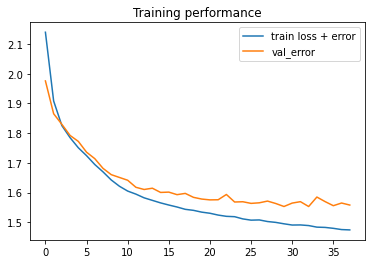

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

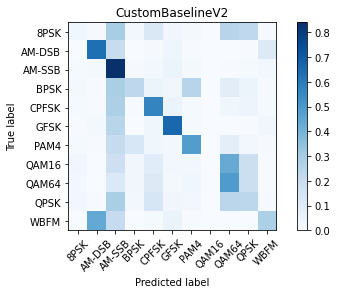

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08729569093610698


Overall Accuracy:  0.10018484288354898
Overall Accuracy:  0.09013785790031813


Overall Accuracy:  0.1163035839775123


Overall Accuracy:  0.13800578034682082


Overall Accuracy:  0.18152524167561762


Overall Accuracy:  0.2726621282694375


Overall Accuracy:  0.3706395348837209


Overall Accuracy:  0.44621938232161873
Overall Accuracy:  0.5621854780733285


Overall Accuracy:  0.574800290486565


Overall Accuracy:  0.5935809592499098


Overall Accuracy:  0.571157495256167


Overall Accuracy:  0.564179104477612
Overall Accuracy:  0.5489913544668588


Overall Accuracy:  0.5698140721837405


Overall Accuracy:  0.5816364309514994


Overall Accuracy:  0.5738999623918767


Overall Accuracy:  0.5939572586588062


Overall Accuracy:  0.5867383512544803


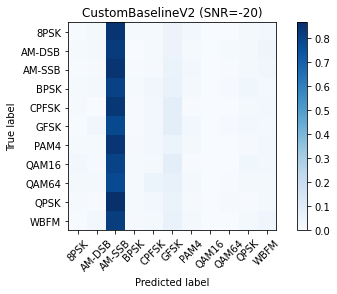

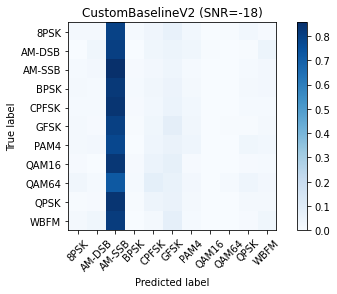

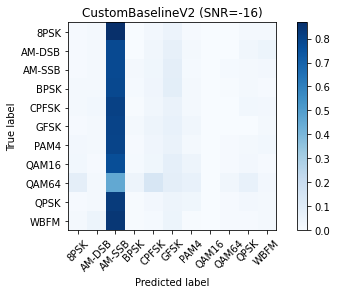

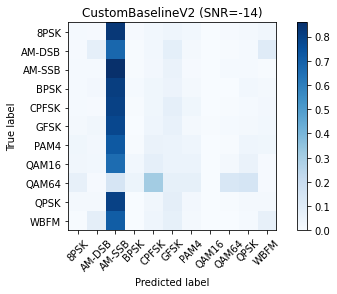

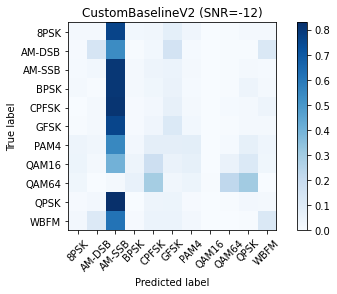

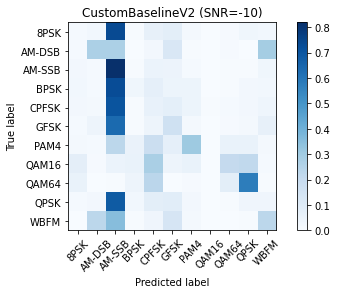

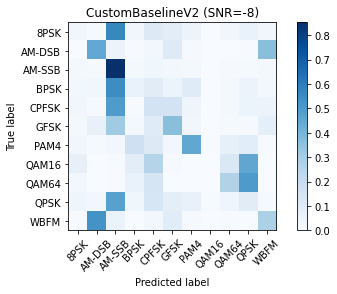

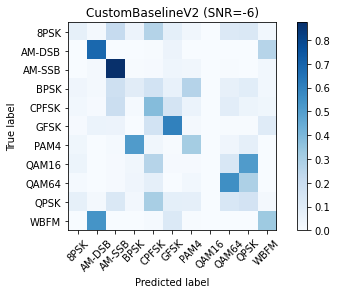

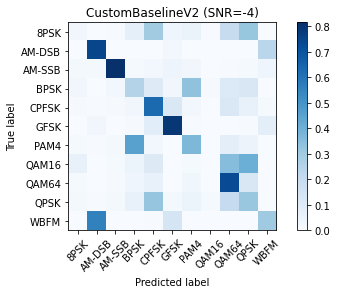

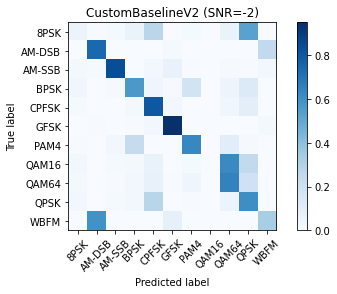

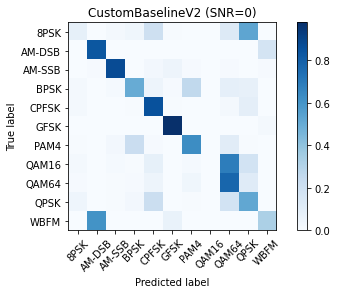

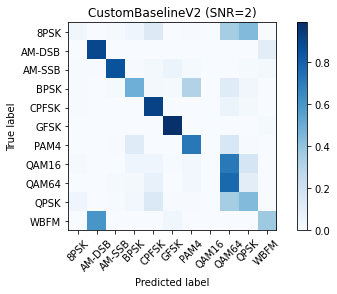

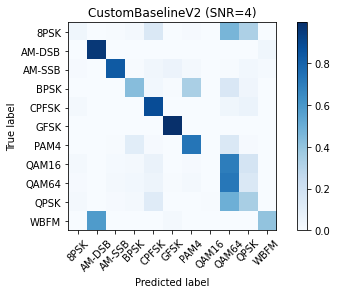

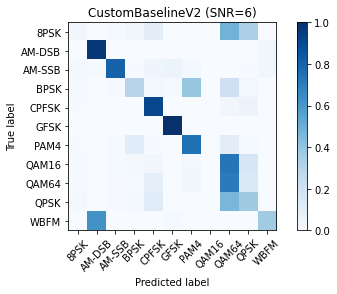

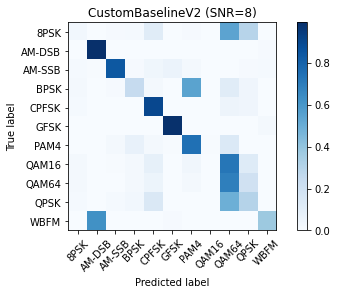

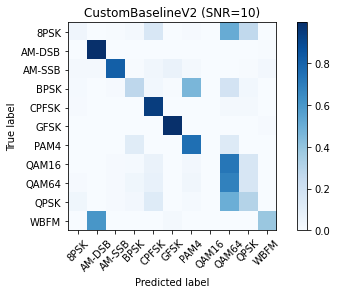

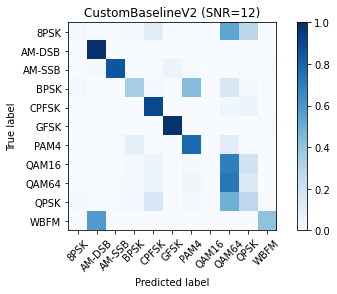

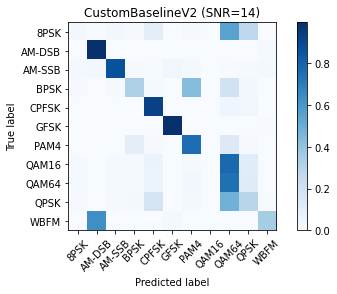

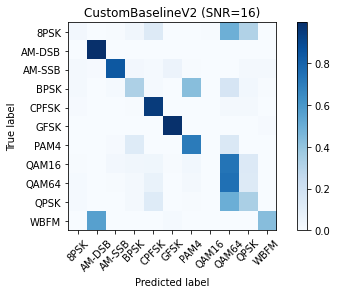

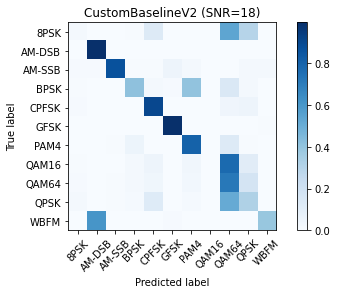

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,10,9,11,13,18,27,37,44,56,57,59,57,56,54,56,58,57,59,58


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

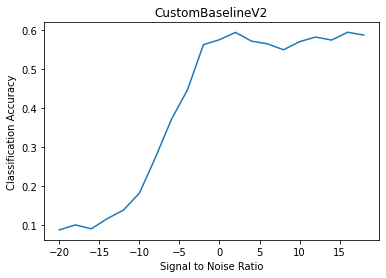

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)